In [3]:
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns 
from itertools import product 
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans,DBSCAN

In [5]:
df=pd.read_csv('data/creditcard_sampledata_3.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [7]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,...,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,...,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,...,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,...,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,...,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [8]:
occ=df['Class'].value_counts()
print(occ)

0    5000
1      50
Name: Class, dtype: int64


We have a class balance problem we can confire it on calculating the ratio.

In [9]:
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')
#As we can see the ratio of fraudulent transactions is very low.

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


In [10]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28 and amount)
    y: label column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [11]:
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15,c='b')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [12]:
X, y = prep_data(df)

In [13]:
print(X)
print(y)

[[-1.33725592e+00 -1.01268723e+00 -3.61656463e-01 ... -1.57676763e-02
   1.07902703e-02  1.89000000e+02]
 [-1.68187486e+00  5.33349336e-01 -3.26064341e-01 ... -1.70682293e-02
   6.35420640e-02  3.15170000e+02]
 [-6.56667445e-01  1.02973756e+00  2.53898951e-01 ... -3.50555792e-02
   1.73125091e-02  5.99800000e+01]
 ...
 [ 2.77308160e+00 -6.75784507e+00  4.44645597e+00 ... -7.66848112e-01
   4.09423944e-01  1.06900000e+02]
 [ 1.86341354e+00 -2.51513548e+00  5.46368065e+00 ... -2.40929959e-01
  -7.81055196e-01  3.24590000e+02]
 [ 6.86619841e+00 -1.18382692e+01  4.19421097e+00 ...  1.17002652e+00
   2.29300915e-01  9.99900000e+01]]
[0 0 0 ... 1 1 1]


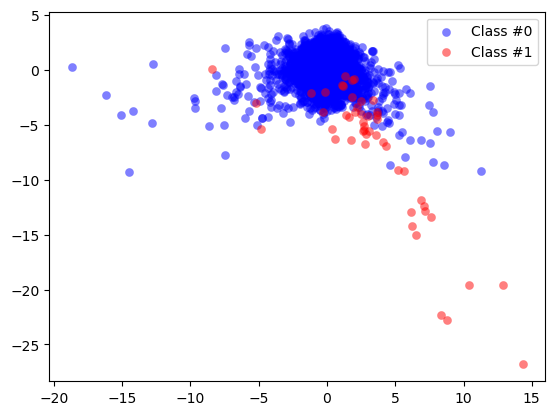

In [14]:
plot_data(X, y)

As we visualize the data,we can see right away how dispersed our fraud cases are across the data and how few there are overall.
How can we improve our fraud to non-fraud balance?(Data Resampling)

The best resampling method is situational
Random Undersampling (RUS):
  If there is a lot of data and many minority cases, then undersampling may be computationally more convenient. In most cases, throwing away data is not desirable
Random Oversampling (ROS):
  Straightforward. Training the model on many duplicates
SMOTE:
  more sophisticated. Realistic data set. Training on synthetic data. Only works well if the minority case features are similar
  if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, introduces noise into the data, as the nearest neighbors might not be fraud cases

 We are going to re-balance our data using the Synthetic Minority Over-sampling Technique (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class.

In [15]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


In [16]:
oversample = SMOTE()

In [17]:
X_resampled, y_resampled = oversample.fit_resample(X, y)

In [18]:
print(f'X shape: {X_resampled.shape}\ny shape: {y_resampled.shape}')

X shape: (10000, 28)
y shape: (10000,)


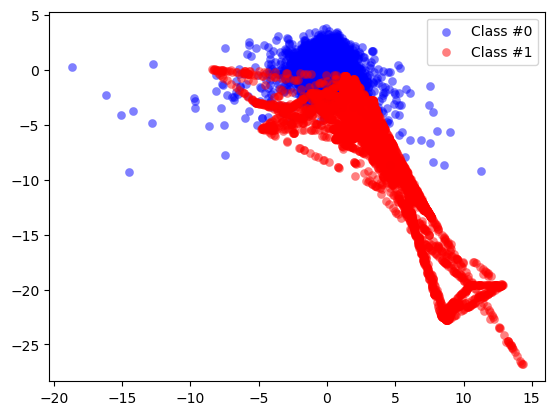

In [19]:
plot_data(X_resampled, y_resampled)

In [20]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

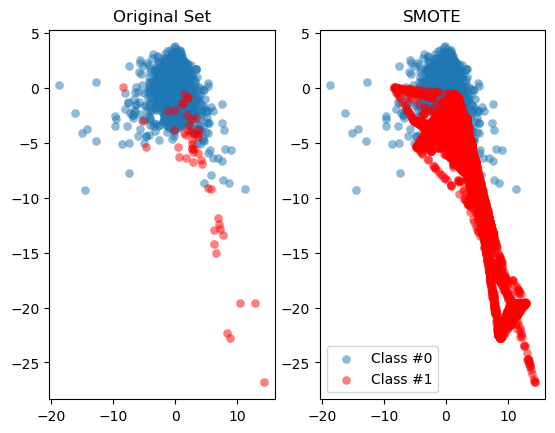

In [21]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

 Visualizing the data shows the effect on the data very clearly. 

Split the features and labels into train and test data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [23]:
model = LinearRegression()

In [24]:
model.fit(X_train, y_train)

LinearRegression()

In [25]:
y_predicted = model.predict(X_test)

In [26]:
r2_score(y_test, y_predicted)

0.8271183628430329

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
model = LinearRegression()

In [29]:
model.fit(X_train, y_train)

LinearRegression()

In [30]:
y_predicted = model.predict(X_test)

In [31]:
r2_score(y_test, y_predicted)

0.6406567377646221

We are going to try finding fraud cases in our credit card dataset the "old way". First you'll define threshold values using common statistics, to split fraud and non-fraud. Then, use those thresholds on your features to detect fraud.

In [32]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [33]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,...,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,...,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,...,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,...,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,...,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [34]:
df.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227,0.001667,...,-0.002896,-0.010583,-0.010206,-0.003305,-0.000918,-0.002613,-0.004651,-0.009584,0.002414,85.843714
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728,-5.917934,...,0.194580,0.703182,0.069065,-0.088374,-0.029425,-0.073336,-0.023377,0.380072,0.009304,113.469000


In [35]:
df['flag_as_fraud']=np.where((df.V1< -3) & (df.V3< -5),1,0 )

In [36]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,flag_as_fraud
0,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,...,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0,0
1,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,...,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0,0
2,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,...,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0,0
3,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,...,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0,0
4,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,...,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0,0


In [37]:
pd.crosstab(df.Class,df.flag_as_fraud,rownames=['Actual Fraud'],colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


 Let's use the Logistic Regression model

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [40]:
predicted=model.predict(X_test)

In [41]:
print('Classification report:\n', classification_report(y_test, predicted))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515



In [42]:
cnf_mat=confusion_matrix(y_true=y_test,y_pred=predicted)
print(cnf_mat)

[[1504    1]
 [   2    8]]


If we compare it with the results of the threshould methode we can see the difference.
The classification methode is more accurate than the threshold method.
We miss 1 fraud transaction, in the old method we miss 28.
Also, we detect 2 normal transactions as frauds, in the old method 16.
So the accuracy is better when we use logistic regression.

We will combine the Logistic Regression model and the SMOTE resampling method, to see what imporvement that maketo our model.(We will use Pipeline to do such combination.)

In [43]:
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [44]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

In [45]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [46]:
print('Classifcation report:\n', classification_report(y_test, predicted))

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.62      1.00      0.77        10

    accuracy                           1.00      1515
   macro avg       0.81      1.00      0.88      1515
weighted avg       1.00      1.00      1.00      1515



In [47]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[1499    6]
 [   0   10]]


The SMOTE improves our resutls,we detect all the frauds but we have higher number of false posities

Now, let us create our first random forest classifier for our peoblem. It will serve as the baseline model that we are going to improve to optimize the accuracy.

In [48]:
df2=pd.read_csv('data/creditcard_sampledata_2.csv')

In [49]:
df2.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,...,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,...,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,...,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,...,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,...,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [50]:
X, y = prep_data(df2)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (7300, 28)
y shape: (7300,)


In [51]:
X[0,:]

array([ 4.28408570e-01,  1.64002800e+00, -1.84885886e+00, -8.70902974e-01,
       -2.04848888e-01, -3.85675453e-01,  3.52792552e-01, -1.09830131e+00,
       -3.34596757e-01, -6.79088729e-01, -3.96709268e-02,  1.37266082e+00,
       -7.32000706e-01, -3.44528134e-01,  1.02475103e+00,  3.80208554e-01,
       -1.08734881e+00,  3.64507163e-01,  5.19236276e-02,  5.07173439e-01,
        1.29256539e+00, -4.67752261e-01,  1.24488683e+00,  6.97706854e-01,
        5.93750372e-02, -3.19964326e-01, -1.74444289e-02,  2.74400000e+01])

In [52]:
df2.Class.value_counts()

0    7000
1     300
Name: Class, dtype: int64

In [53]:
total_obs=len(y)
print(total_obs)

7300


In [54]:
non_fraud=[i for i in y if i==0]
nub_non_fraud=non_fraud.count(0)
print(nub_non_fraud)

7000


In [55]:
percentage=(nub_non_fraud/total_obs )*100
print(f'{percentage:0.2f}%')

95.89%


By doing nothing we have a 95.89% of accuracy. Lets see how can we improve that using random forest.

In [56]:
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [57]:
print(X_train.shape)
X_test.shape

(5110, 28)


(2190, 28)

In [58]:
model=RandomForestClassifier(random_state=5,n_estimators=20)

In [59]:
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [60]:
predicted=model.predict(X_test)

In [61]:
predicted.shape

(2190,)

In [62]:
print(f'Accuraccy score :\n{accuracy_score(y_test,predicted)*100:0.2f}%')

Accuraccy score :
99.09%


The benefit of using Random Forest is that it prevents overfitting, because it combines the subtrees of submsamples of features.

With such problem(imbaleced data) the accuracy can be a miseleading to evaluate our model.
So lets use the classification_report

In [63]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190



In [64]:
probs=model.predict_proba(X_test)
probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [65]:
print(f'ROC Score : {roc_auc_score(y_test, probs[:,1]): 0.2f}')
print(f'Confusion Martix: \n{confusion_matrix(y_test,predicted)}')

ROC Score :  0.94
Confusion Martix: 
[[2097    2]
 [  18   73]]


To investigate the trade-off between precision and recall curve. We need a balance between these two in our model.Otherwise we might end up with many false positives, or not enough actual fraud cases caught. 

In [66]:
average_precision=average_precision_score(y_test,predicted)
average_precision

0.7890250388880526

In [67]:
precision,recall,_=precision_recall_curve(y_test,predicted)
print(f'precision: {precision} \n recall: {recall}')

precision: [0.04155251 0.97333333 1.        ] 
 recall: [1.        0.8021978 0.       ]


In [68]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

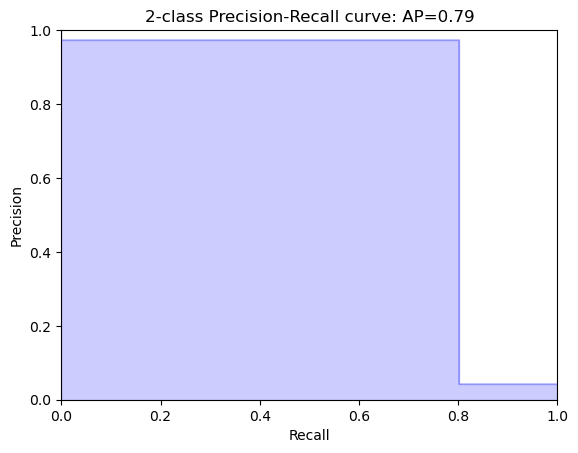

In [69]:
plot_pr_curve(recall,precision,average_precision)

To optimaze our Random Forest model we will change Hyperparameter of RandomForestClassifier using GridSearchCV.But first we will use class_weights option when defining the sklearn model.

In [70]:
model=RandomForestClassifier(class_weight='balanced_subsample',random_state=5,n_estimators=100)

In [71]:
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

In [72]:
predicted=model.predict(X_test)
prob=model.predict_proba(X_test)

In [73]:
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2098    1]
 [  18   73]]


We now have 3 less false positives, but now 19 in stead of 18 false negatives.The model don't improve drastically.
Now lets adjust Random forest parameters.

In [74]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [75]:
model=RandomForestClassifier(bootstrap=True,class_weight={0:1,1:12},criterion='entropy',max_depth=10,min_samples_leaf=10,n_estimators=20,n_jobs=1,random_state=5)

In [76]:
get_model_results(X_train,y_train,X_test,y_test,model)

ROC Score:
0.9609651901219315

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  14   77]]


We can see that our model improves.Lets see if we use GridSearchCV.

In [77]:
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

In [78]:
model=RandomForestClassifier(random_state=5)

In [79]:
Cv_model=GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='recall',n_jobs=-1)

In [80]:
Cv_model.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 10, 12],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [1, 30]},
             scoring='recall')

In [81]:
Cv_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

In [82]:
model=RandomForestClassifier(random_state=5,min_samples_leaf=10,class_weight={0:1,1:12},criterion='gini',max_depth=8,max_features='log2',n_estimators=30,n_jobs=-1)

In [83]:
get_model_results(X_train,y_train,X_test,y_test,model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


We can see that the model improves even further. Now we are catching more cases of fraud. However, you see that the number of false positives actually went up(Precision-Recall trade-off in action)

Ensemble methods are techniques that create multiple machine learning models and then combine them to produce a final result.
We will use Voting Classifier.
We will combine three algorithms to our model to improve it.

We will combine LogisticRegression, our optimal Random Forest and a Decision tree with balanced weights. 

First lets check our first model standalone model Logistic Regression.

In [84]:
model=LogisticRegression(class_weight={0:1,1:15},random_state=5,solver='liblinear')
get_model_results(X_train,y_train,X_test,y_test,model)

ROC Score:
0.9722054981702433

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

    accuracy                           0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190


Confusion Matrix:
[[2052   47]
 [  11   80]]


More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model.

In [85]:
clf1=LogisticRegression(class_weight={0:1,1:15},random_state=5,solver='liblinear')

clf2=RandomForestClassifier(bootstrap=True,class_weight={0:1,1:12},criterion='entropy',max_depth=10,min_samples_leaf=10,n_estimators=20,n_jobs=1,random_state=5)

clf3=DecisionTreeClassifier(random_state=5,class_weight="balanced")
ensemble_model=VotingClassifier(estimators=[('l',clf1),('r',clf2),('d',clf3)],voting='hard')
get_model_results(X_train,y_train,X_test,y_test,ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.92      0.86      0.89        91

    accuracy                           0.99      2190
   macro avg       0.96      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2092    7]
 [  13   78]]


We increase the cases of fraud we are catching from 76 to 78, and  only have 5 extra false positives in return. If we do care about catching as many fraud cases as we can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together we indeed managed to improve performance.

In [86]:
ensemble_model=VotingClassifier(estimators=[('l',clf1),('r',clf2),('d',clf3)],voting='soft',weights=[1,4,1],flatten_transform=True)
get_model_results(X_train,y_train,X_test,y_test,ensemble_model)

ROC Score:
0.9692004041694371

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.85      0.90        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  14   77]]


The weight option allows us to play with the individual models to get the best final mix for our fraud detection model. Now that we have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when we don't have any labels to train on.

Now, we will use unsupervised learning techniques to detect fraud.Such us Segment customers, K-means clustering and other clustering algorithms to find suspicious occurrences in our data.

We have a bank payment transaction data lets explore our data to distinguish normal from abnormal.

In [87]:
banksim_df=pd.read_csv('data/banksim.csv')
banksim_df.drop(['Unnamed: 0'],axis=1,inplace=True)
banksim_df_adj=pd.read_csv('data/banksim_adj.csv')
banksim_df_adj.drop(['Unnamed: 0'],axis=1,inplace=True)

In [88]:
banksim_df.head() 

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [89]:
banksim_df_adj.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [90]:
print(banksim_df.shape)
print(banksim_df_adj.shape)

(7200, 5)
(7189, 18)


In [91]:
banksim_df_cat=banksim_df[['category','amount','fraud']].groupby(['category']).mean()
banksim_df_cat

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


As we can see the majority of leisure, travel and sportsandtoys categories are fraud.

In [92]:
banksim_df_age=banksim_df.groupby(['age']).mean()
banksim_df_age

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


In [93]:
banksim_df.age.value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

We can conclude anything special.

In [94]:
df_fraud=banksim_df[banksim_df['fraud']==1]
df_no_fraud=banksim_df[banksim_df['fraud']==0]
print(f'shape of df_fraud{df_fraud.shape}')
print(f'shape of df_no_fraud{df_no_fraud.shape}')

shape of df_fraud(200, 5)
shape of df_no_fraud(7000, 5)


In [95]:
df_fraud.head()

,age,gender,category,amount,fraud
7000,4,M,es_sportsandtoys,157.3700,1
7001,3,M,es_travel,236.1474,1
7002,2,F,es_hotelservices,236.1474,1
7003,1,F,es_sportsandtoys,70.7500,1
7004,1,M,es_hotelservices,65.1900,1


In [96]:
df_no_fraud.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


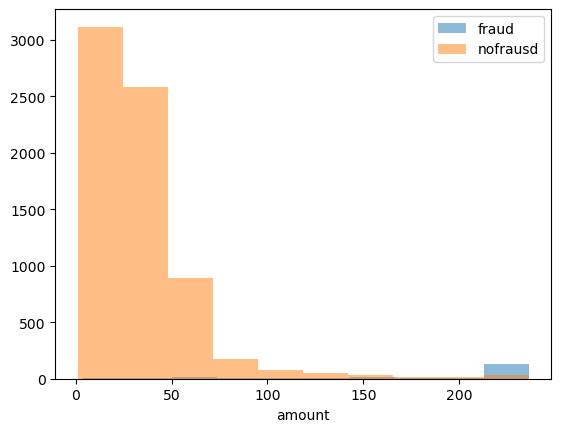

In [97]:
plt.hist(df_fraud.amount,alpha=0.5,label='fraud')
plt.hist(df_no_fraud.amount,alpha=0.5,label='nofrausd')
plt.xlabel('amount')
plt.legend()
plt.show()

We can see that the fraud transactions are more when we have a big amount.This is a good news, as it will help us later in detecting fraud from non fraud transactions.

For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidean distance to assess distance to cluster centroids, therefore we first need to scale our data before continuing to implement the algorithm. Let's do that first.

In [98]:
labels=banksim_df_adj.fraud
banksim_df_adj.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [99]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [100]:
X=banksim_df_adj[cols].values.astype(np.float)
X.shape

(7189, 17)

In [101]:
X.mean()

2.4345457504520787

(array([[7189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [1459., 1549., 1476., 1162.,  671.,  285.,  121.,   68.,   52.,
           30.,   33.,   30.,   21.,   27.,    9.,   14.,    9.,   12.,
           10.,  151.],
        [7189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [7189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [7189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [7189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0., 

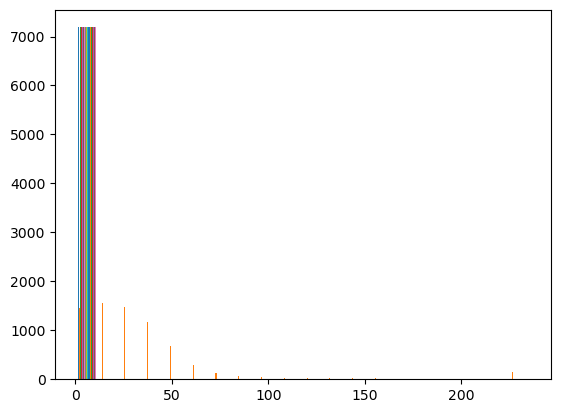

In [102]:
plt.hist(X,bins=20)

In [103]:
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)
X_scaled.mean()

0.12177527550573702

(array([[  40.,  713.,    0., 2333.,    0., 1718., 1279.,    0.,  792.,
          314.],
        [3117., 2590.,  905.,  184.,   80.,   60.,   48.,   24.,   20.,
          161.],
        [3977.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3212.],
        [7100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           89.],
        [7176.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           13.],
        [7092.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           97.],
        [6896.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          293.],
        [6946.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          243.],
        [7165.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           24.],
        [7159.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           30.],
        [7109.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           80.],
        [7176.,    0.

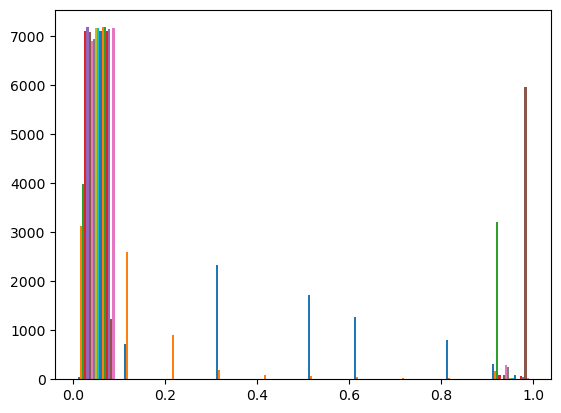

In [104]:
plt.hist(X_scaled)

We can see the difference between the two distibution.

We will use the MiniBatch K-means, because we have a large dataset.

In [105]:
kmeans=MiniBatchKMeans(n_clusters=8,random_state=0)
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

And now  We will use Elbow method to find what the optimal number of clusters should be based on this method.To optimize our model.

In [108]:
n=range(1,10)
kmeans=[MiniBatchKMeans(n_clusters=i) for i in n]
score=[kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

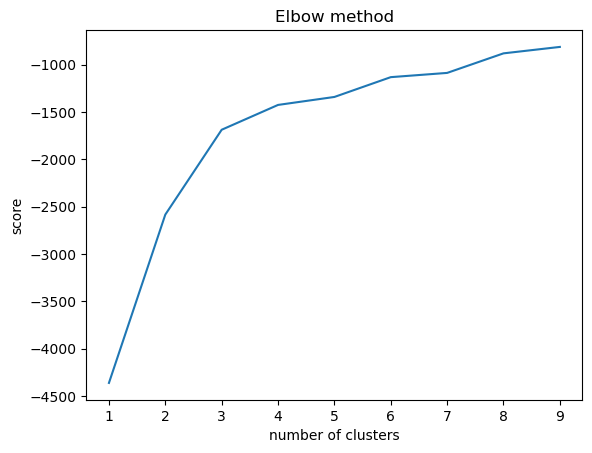

In [117]:
plt.plot(n,score)
plt.xlabel('number of clusters')
plt.ylabel('score')
plt.title('Elbow method')
plt.show()

The optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve.